# Q Function Approximation (FA) for the Mountain Car env


## Learning goals
- motivation for FA 
- FA vs. Supervised Learning
- understand key concepts in FA: Experience Replay, Semi-gradient methods, featurization, batches, fixed target
- understand convergence properties of different FAs
- learn to solve the Mountain Car environment

In [1]:
import gym
import itertools
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import os
from gym import wrappers

if "../../" not in sys.path:
  sys.path.append("../../")

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

## Playing with the environment
- details: [Environment](https://github.com/openai/gym/wiki/MountainCar-v0)
- state: velocity and position
- action: accelerate left, right, or no acceleration
- episodic: True
- stochatic: True? (initial position)
- reward: -1 per time step
- goal: position of 0.5

[2017-03-22 16:02:52,063] Making new env: MountainCar-v0


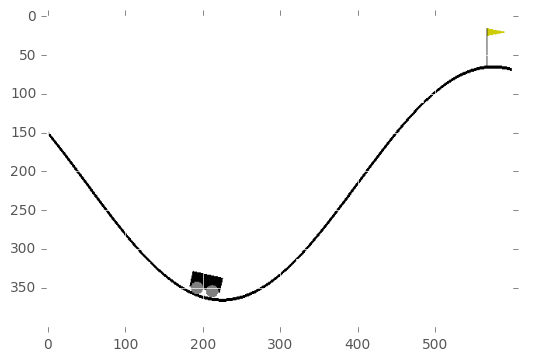

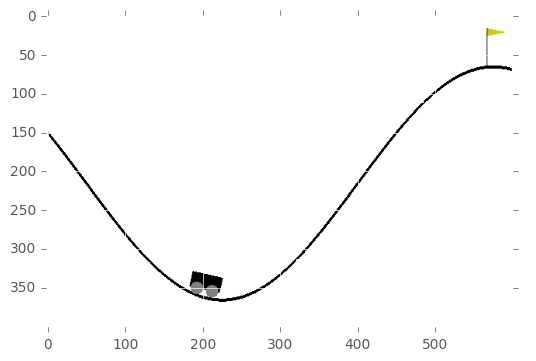

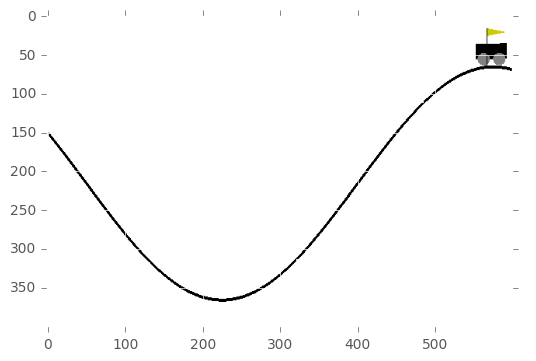

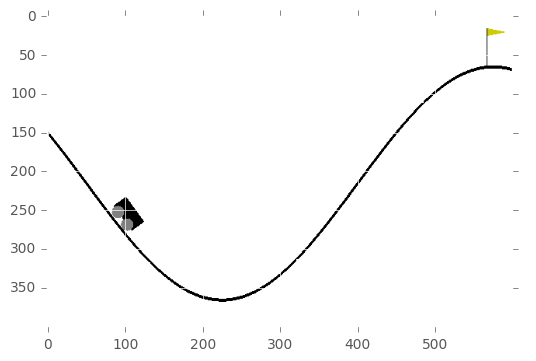

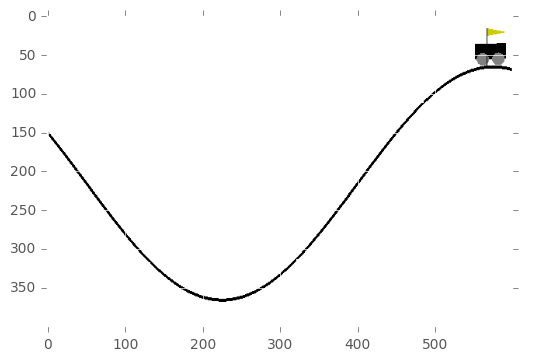

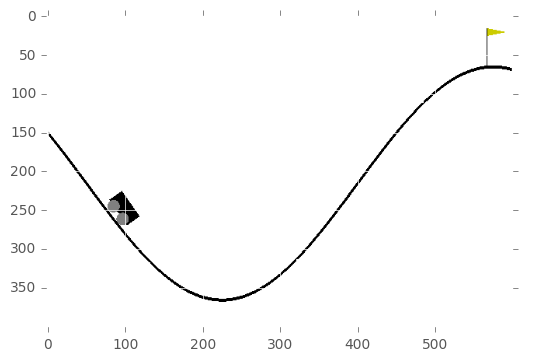

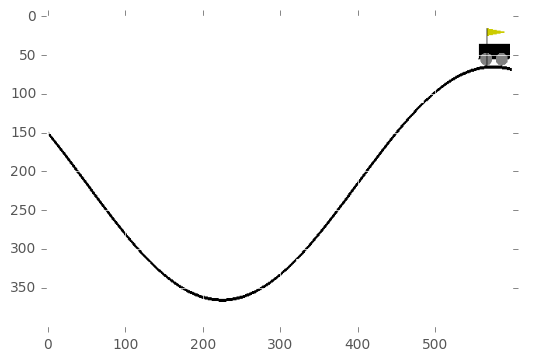

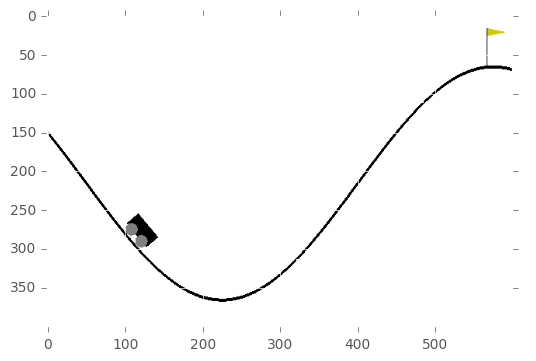

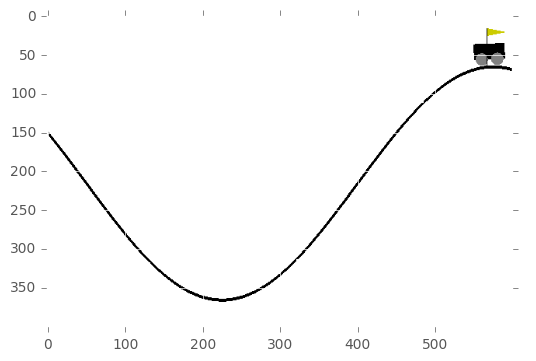

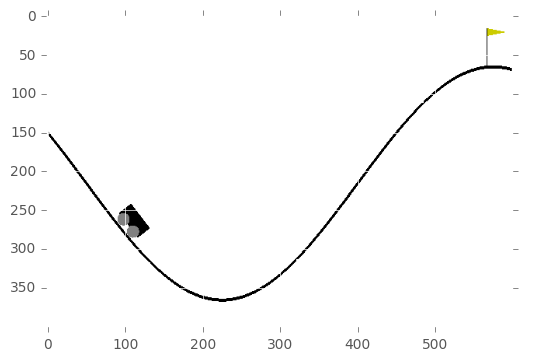

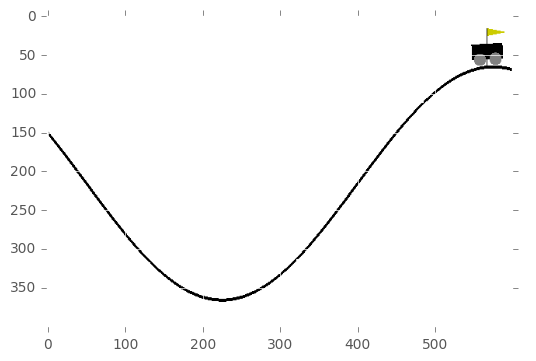

In [13]:
env = gym.envs.make("MountainCar-v0")
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

# t % 200 -> arbitrary goal

# super-naive policy: just keep pressing left
for t in range(1000):
    env.step(0)
    if done or t % 200 == 0:
        plt.figure()
        plt.imshow(env.render(mode='rgb_array'))
        env.reset()

# smarter policy: alterante left to right every 50 timesteps
# default_action = 0 # left
# for t in range(1000):
#     _, _, done, _ = env.step(default_action)
#     if t % 50 == 0:
#         default_action = 0 if default_action == 2 else 2        
#     if done or t % 200 == 0:
#         plt.figure()
#         plt.imshow(env.render(mode='rgb_array'))
#         env.reset()

env.render(close=True)
plt.show()

## observations
- state space is continuous. Tabular methods would be inappropriate
- velocity and position appear interactive, because e.g. being at a position = 0.1 may be good or bad depending on the velocity.
- Thus, we might benefit from featurizing the state.
- since the state is 2d, we could consider coarse coding (binary vectors) or RBF, let's try out both

## implement Linear function approximation

1. feature construction (we will use RBF)
2. implement linear estimator (we will use SGDRegressor)
3. do the q-learning
4. check the performance


In [ ]:
# Feature Construction
env = gym.envs.make("MountainCar-v0")
env = wrappers.Monitor(env, '/tmp/mtcar-experiment-1', force=True)

# RBF uses Euclidean distance in its formation so we'd better standarize our inputs
# scaler.tranform(state) -> mean = 0, variance = 1
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# I did not quite understand the code below. Perhaps the original author wanted to
# use varying gamma values to smooth out the risk of choosing a bad gamma.
# RBFSampler basically approximates RBF Kernel
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])

featurizer.fit(scaler.transform(observation_examples))

In [14]:
class Estimator():
    """
    Value Function approximator.
    """

    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)

    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]

    def predict(self, s, a=None):
        """
        Makes value function predictions.

        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for

        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.

        """
        # TODO: Implement this!
        X = [self.featurize_state(s)]
        if a:
            pred = self.models[a].predict(X)[0]
        else:
            preds = np.zeros(env.action_space.n)
            for i in range(env.action_space.n):
                preds[i] = self.models[i].predict(X)[0]
        return pred if a else preds

    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """

        # TODO: Implement this!
        X = [self.featurize_state(s)]
        self.models[a].partial_fit(X, [y])
        return None

def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    for i_episode in range(num_episodes):

        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)

        sys.stdout.flush()

        # TODO: Implement this!
        # decay epsilon
        s = env.reset()
        rAll = 0
        # TODO: accomodate SARSA
        for t in itertools.count():
            probs = policy(s)
            a = np.random.choice(np.arange(len(probs)), p=probs)

            next_s, r, done, _ = env.step(a)

            next_q_values = estimator.predict(next_s)
            td_target = r + discount_factor * np.max(next_q_values)

            estimator.update(s, a, td_target)

            if done:
                break

            rAll += r
            s = next_s

        stats.episode_rewards[i_episode] = rAll
        stats.episode_lengths[i_episode] = t
    return stats

def is_solved(stats, target, interval):
    """
    checks if openai's criteria has been met
    """
    # FrozenLake-v0 is considered "solved" when the agent
    # obtains an average reward of at least 0.78 over 100
    # consecutive episodes.
    avg_reward = np.sum(stats.episode_rewards)/len(stats.episode_rewards)
    print("Average reward : {}".format(avg_reward))

    def moving_avg(x, n=100):
        return np.convolve(x, np.ones((n,))/n, mode='valid')

    ma = moving_avg(stats.episode_rewards, interval)
    peaks = np.where(ma > target)[0]
    if len(peaks) > 0:
        print("solved after {} episodes".format(peaks[0]))
        return True
    else:
        print("did not pass the openai criteria")
        return False

In [6]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
estimator = Estimator()
stats = q_learning(env, estimator, 100, epsilon=0.0)
env.close()

TARGET_AVG_REWARD = -100.0
TARGET_EPISODE_INTERVAL = 100

if is_solved(stats, TARGET_AVG_REWARD, TARGET_EPISODE_INTERVAL):
    OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
    gym.upload('/tmp/mtcar-experiment-1', api_key=OPENAI_API_KEY)

[2017-03-22 12:40:27,369] Making new env: MountainCar-v0
[2017-03-22 12:40:27,384] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-22 12:40:27,386] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-03-22 12:40:27,577] Starting new video recorder writing to /tmp/mtcar-experiment-1/openaigym.video.2.2419.video000000.mp4
[2017-03-22 12:40:27,791] Starting new video recorder writing to /tmp/mtcar-experiment-1/openaigym.video.2.2419.video000001.mp4
[2017-03-22 12:40:30,936] Starting new video recorder writing to /tmp/mtcar-experiment-1/openaigym.video.2.2419.video000008.mp4
[2017-03-22 12:40:49,034] Starting new video recorder writing to /tmp/mtcar-experiment-1/openaigym.video.2.2419.video000027.mp4
[2017-03-22 12:41:19,905] Starting new video record

Average reward : -182.91
did not pass the openai criteria


## implement non-linear function approximation


## Tricks to solve the env

- RBF
- Tile coding
- coarse coding
- featurize vs. not featurize (leave as linear) - account for interactions between states

